<a href="https://colab.research.google.com/github/ReynaldiJ/portfolio/blob/main/Image_CLassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as tfs
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"reynaldijoely","key":"0babfd8e92435f234ea4f98767c5d10e"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
! kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset          Customer Shopping Trends Dataset                 146KB  2023-10-05 06:45:37          21074        448  1.0              
samyakb/student-stress-factors                              Student stress factors                            887B  2023-11-02 12:42:11           2056         49  0.9411765        
nelgiriyewithana/billionaires-statistics-dataset            Billionaires Statistics Dataset (2023)           139KB  2023-09-29 13:39:28          11535        279  1.0              
adeolaadesina/factors-affecting-children-anemia-level       Factors Affecting Children Anemia L

In [ ]:
!kaggle datasets download -d ajayrana/hymenoptera-data

 90% 81.0M/90.2M [00:01<00:00, 87.6MB/s]
100% 90.2M/90.2M [00:01<00:00, 80.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('hymenoptera-data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print('{} CONTAINS {} files'.format(dirname, len(filenames)))

In [ ]:
INPUT_DIR = '/content/hymenoptera_data/hymenoptera_data'
# Imagenet mean and standard (are calculated from all of images)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 4

In [ ]:
data_tfs = {
    'train': tfs.Compose([
        tfs.Resize(300),
        tfs.RandomCrop(244),
        tfs.RandomHorizontalFlip(),
        tfs.ToTensor(),
        tfs.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
    'val': tfs.Compose([
        tfs.Resize(256),
        tfs.CenterCrop(244),
        tfs.ToTensor(),
        tfs.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
}

dataset = {ds: torchvision.datasets.ImageFolder(
    root=os.path.join(INPUT_DIR, ds),
    transform=data_tfs[ds]
) for ds in ['train', 'val']}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'val']}
dataset_classes = dataset['train'].classes
print('classes:', dataset_classes, '\nsize', dataset_size)

dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=2
    ),
    'val': torch.utils.data.DataLoader(
        dataset=dataset['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2
    ),
}

classes: ['ants', 'bees'] 
size {'train': 244, 'val': 153}


In [ ]:
def get_batches(dataloader, num_of_batches=3):
    assert(num_of_batches > 0)
    images, classes = next(iter(dataloader))
    for _ in range(num_of_batches - 1):
        image_batch, cls_batch = next(iter(dataloader))
        images = torch.cat([images, image_batch], dim=0)
        classes = torch.cat([classes, cls_batch], dim=0)
    return images, classes

In [ ]:
def show_batches(images, classes):
    cols = (images.shape[0] + 3) // 4
    images = images.numpy().transpose(0,2,3,1)
    images = images * IMAGENET_STD + IMAGENET_MEAN
    fig, axes = plt.subplots(cols, 4, figsize=(12, cols * 3))
    for ax, img, img_cls in zip(axes.flatten(), images, classes.numpy()):
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_xlabel(dataset_classes[img_cls], fontsize=20)
    plt.tight_layout()
    plt.show()

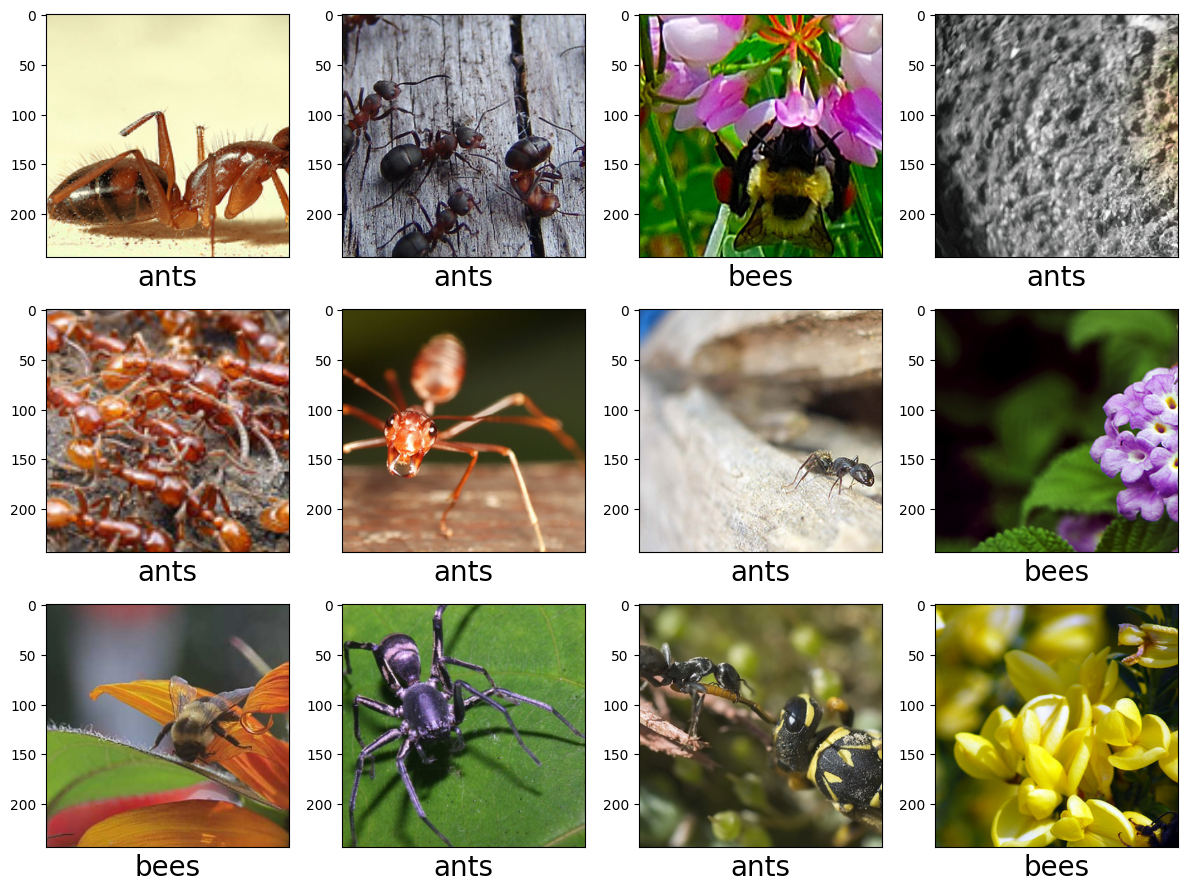

In [ ]:
images, classes = get_batches(dataloader['train'])
show_batches(images, classes)

In [ ]:
def show_metrics(metrics):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['train'], label='train')
    plt.plot(metrics['val'], label='val')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
def train_model(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.nn.Module,
    sheduler: torch.nn.Module,
    epochs: int = 25
) -> (torch.nn.Module, dict):
    r"""Training the model. Returns best model, dictionary of train and validation losses, dictionary of train and validation accuracies.
    Args:
        model (torch.nn.Module): Neural network
        criterion (torch.nn.Module): Cost function
        optimizer (torch.nn.Module): Optimization algorithm
        sheduler (torch.nn.Module): Learning rate change policy
        epochs (int): Number of training iterations. Default: 25
    """

    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    best_model_weights = model.state_dict()
    best_accuracy = 0.
    progress = tqdm(range(epochs), desc='Epoch:')

    for epoch in progress:
        for phase in ['train', 'val']:
            loss_accum = 0.
            corr_accum = 0
            model.train(mode=(phase == 'train'))

            for inputs, labels in tqdm(dataloader[phase], desc=f'Phase {phase}:'):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                if phase == 'train':
                    optimizer.zero_grad()
                    outp = model(inputs)
                    loss = criterion(outp, labels)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp = model(inputs)
                        loss = criterion(outp, labels)

                preds = torch.argmax(outp, -1)
                loss_accum += loss.item()
                corr_accum += (preds == labels.data).sum()

            if phase == 'train':
                sheduler.step()

            epoch_loss = loss_accum / dataset_size[phase]
            epoch_accuracy = corr_accum / dataset_size[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_accuracy)
            progress.set_description('loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_accuracy))
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = model.state_dict()

    model.load_state_dict(best_model_weights)
    return model, losses, accuracies

In [ ]:
model = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 87.6MB/s]


In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
num_in_features = 9216
num_out_features = 2

model.classifier = torch.nn.Linear(num_in_features, num_out_features)
model.to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model, losses, accuracies = train_model(model, loss, optimizer, sheduler)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

Phase train::   0%|          | 0/61 [00:00<?, ?it/s]

Phase val::   0%|          | 0/39 [00:00<?, ?it/s]

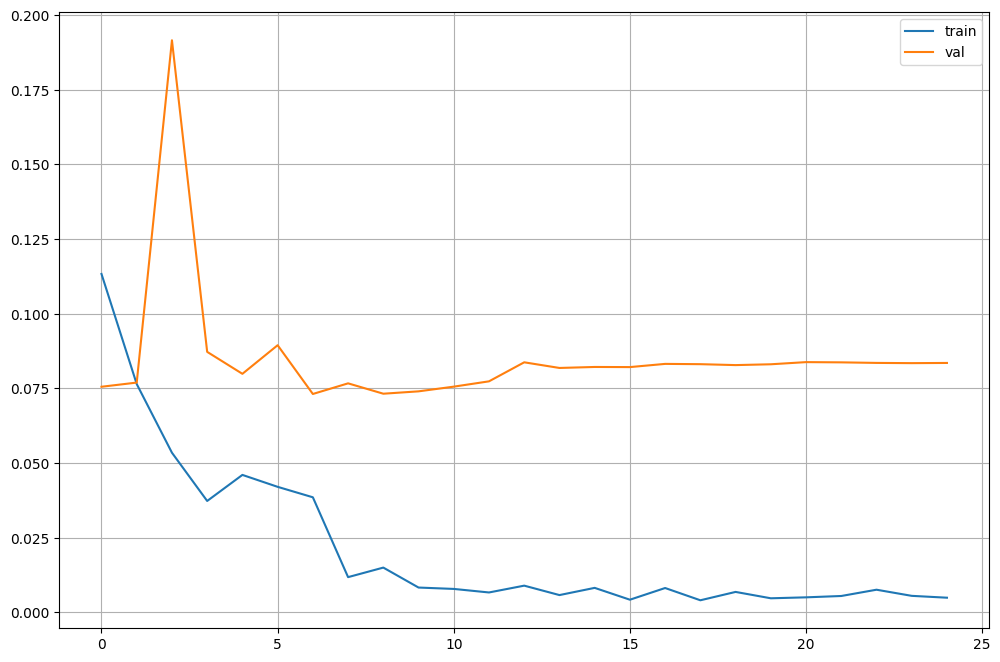

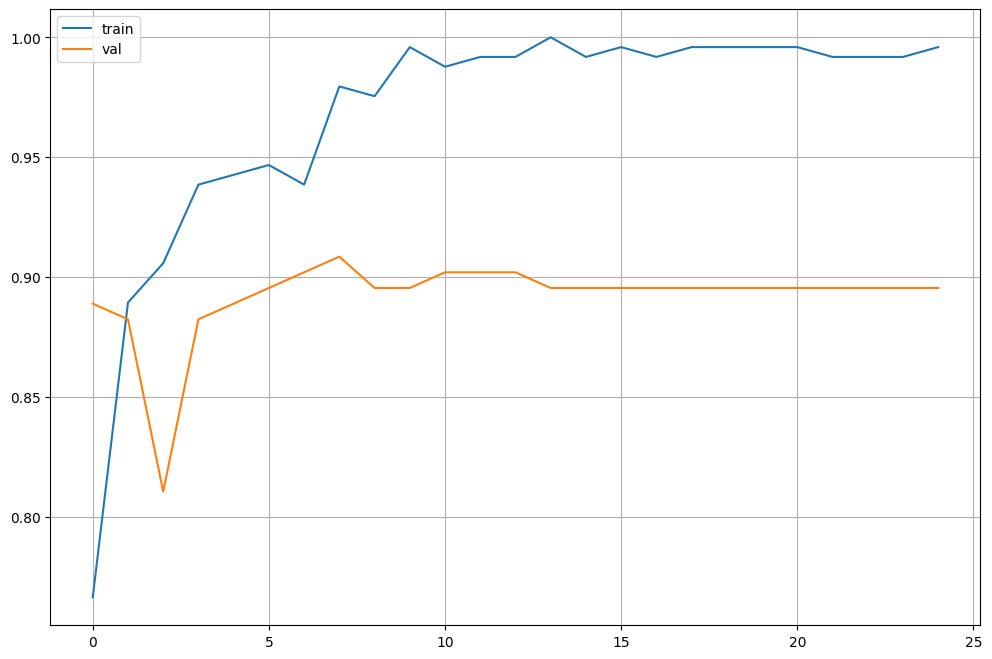

tensor(0.9085)

In [ ]:
show_metrics(losses)
show_metrics(accuracies)
max(accuracies['val'])